In [69]:
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import glob
from Curve_fitting_with_scipy import Gaussianfitting as Gf
from Curve_fitting_with_scipy import Linefitting as Lf
from scipy.signal import fftconvolve
from collections import defaultdict
import PIL
import joblib
from tqdm import tqdm
import pickle



from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import root_mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression



from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier, XGBRFRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor



import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transformers
from torch.utils.data import Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


from Torch_modules.classes import FullyConnectedNeuralNetwork, TorchPipeline, get_numerical_categorical_boolean_columns
from Torch_modules.classes import TotalImputer, CategoricalToNumerical, NumericalNormalizedScaler, NumericalStandardScaler
from Torch_modules.classes import ConvolutionalNeuralNetwork


import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'
#mpl.rcParams['font.style'] = 'italic'  # Set this to 'italic'
mpl.rcParams['figure.dpi'] = 120  # highres display

In [70]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [71]:
filename_train = glob.glob("D:\\ML Dataset\\cifar-10-python\\train data\\*")
filename_test = "D:\\ML Dataset\\cifar-10-python\\test data\\test_batch"
filename_map = "D:\\ML Dataset\\cifar-10-python\\batches.meta"

In [72]:
map_dict = unpickle(filename_map)
map = np.array(map_dict[b"label_names"],dtype=str)

In [73]:
data_dict = unpickle(filename_train[0])
x_train = np.array(data_dict[b"data"])
y_train = np.array(data_dict[b"labels"])

for filename in filename_train[1:]:
    data_dict = unpickle(filename)
    x_train = np.concatenate((x_train,np.array(data_dict[b"data"])),axis=0)
    y_train = np.concatenate((y_train,np.array(data_dict[b"labels"])),axis=0)

print(f"x_train.shape: {x_train.shape};  y_train.shape: {y_train.shape}")


data_dict = unpickle(filename_test)
x_test = np.array(data_dict[b"data"])
y_test = np.array(data_dict[b"labels"])
print(f"x_test.shape: {x_test.shape};  y_test.shape: {y_test.shape}")

del data_dict

x_train.shape: (50000, 3072);  y_train.shape: (50000,)
x_test.shape: (10000, 3072);  y_test.shape: (10000,)


In [74]:
x_train = x_train.reshape(-1,3,32,32)
x_test = x_test.reshape(-1,3,32,32)

x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)

x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)

# Ensure that y_train is a LongTensor otherwise it will throw error while calculating accuracy
y_train = y_train.long()
# If you're using x_test and y_test in a similar manner, ensure you convert them too:
y_test = y_test.long()

image_width = x_train.shape[2]
image_height = x_train.shape[3]
image_channel = x_train.shape[1]

In [75]:
# Example usage:

# Define the conv layers as specified
conv_layers = [
    (1,1,1,0),
    (16, 2, 1, 0),  # Conv layer 1: 16 filters, 4x4 kernel, stride 1, padding 1
    (32, 2, 1, 0),  # Conv layer 2: 32 filters, 3x3 kernel, stride 1, padding 0
    (64, 2, 1, 0),  # Conv layer 3: 64 filters, 4x4 kernel, stride 1, padding 0
]
pool_kernels = [2, 2, 2, 2]  # Different pooling kernels for each layer
pooling_types = ["no", "no","max","avg"]  # Different pooling types for each layer


# Define fully connected layers
fc_layers_dims = [2048, 512, 256, 128] # excludind first layer (output_of_conv -> input_on_fc)
output_dimension=len(set(np.array(y_train)))

# Instantiate the model
model = ConvolutionalNeuralNetwork(conv_layers=conv_layers,
                                   fc_layers_dims=fc_layers_dims,
                                   in_channels=image_channel,
                                   output_dimension=output_dimension, 
                                   pooling_types=pooling_types, 
                                   pool_kernels=pool_kernels)
learning_rate = 0.001
batch_size = 400
epochs = 10

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [76]:
# Create the pipeline object
torchpipeline = TorchPipeline(model=model, 
                         criterion=criterion, 
                         optimizer=optimizer, 
                         batch_size=batch_size, 
                         epochs=epochs)

In [77]:
# Fitting the model
torchpipeline.fit(x_train, y_train, print_after=25)

Epoch 1/10: 100%|█████████████████████████████████████████████████|50000/50000 [100%], Loss=2.270127


Epoch 2/10: 100%|█████████████████████████████████████████████████|50000/50000 [100%], Loss=2.253753


Epoch 3/10: 100%|█████████████████████████████████████████████████|50000/50000 [100%], Loss=2.241857


Epoch 4/10: 100%|█████████████████████████████████████████████████|50000/50000 [100%], Loss=2.226820


Epoch 5/10: 100%|█████████████████████████████████████████████████|50000/50000 [100%], Loss=2.177098


Epoch 6/10: 100%|█████████████████████████████████████████████████|50000/50000 [100%], Loss=2.158281


Epoch 7/10: 100%|█████████████████████████████████████████████████|50000/50000 [100%], Loss=2.142689


Epoch 8/10: 100%|█████████████████████████████████████████████████|50000/50000 [100%], Loss=2.119237


Epoch 9/10: 100%|█████████████████████████████████████████████████|50000/50000 [100%], Loss=2.095459


Epoch 10/10: 100%|████████████████████████████████████████████████|50000/50000 [100%], Loss=2.070163

In [78]:
# Making predictions
y_predict, accuracy = torchpipeline.predict(x_test, y_test, device)


Test set: Accuracy: 2526/10000 (25%)



In [79]:
model

ConvolutionalNeuralNetwork(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
    (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=3136, out_features=2048, bias=True)
    (1): Linear(in_features=2048, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [80]:
x_train.shape

torch.Size([50000, 3, 32, 32])

In [81]:
def show_image():
    rand = np.random.randint(low=0, high=20000)
    image = x_train[rand]
    image = image.permute(1, 2, 0)  # Change from (3, 32, 32) to (32, 32, 3)
    image = np.array(image)
    label_name = map[int(y_train[rand])]
    plt.imshow(image)
    plt.title(label_name)
    plt.show()

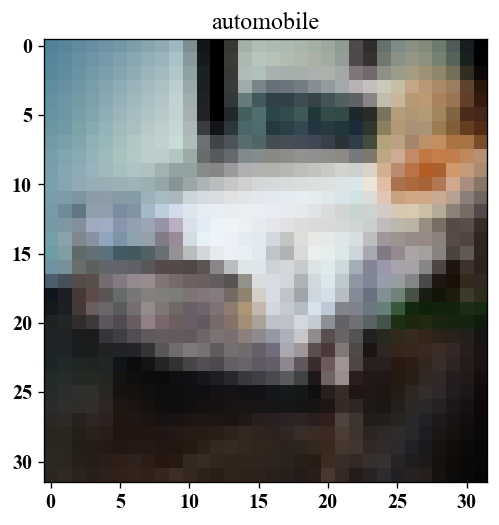

In [82]:
show_image()